In [458]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report,plot_confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import cross_val_score

In [459]:

# Represents the proportion of the dataset used for training. Remaining will be used for validation.
TRAIN_SIZE = 0.7

In [460]:
# Load dataset

source = pd.read_csv("./SAKI Exercise 1 - Transaction Classification - Data Set.csv", delimiter=";")
source.drop("Unnamed: 0", axis=1, inplace=True)

source.head()



,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure


In [461]:
# Extract relevant features and concatenate them to a single string per feature

# Removing some characters could be helpful.
# However these are almost always part of a word and are not surrounded by whitespace.
# Hence they are not detected as a single token by the count tokenizer and it 
# increases the accuracy by a very tiny amount, though that might change with a 
# bigger dataset
def remove_stopwords(feature: str)-> str:
    feature = feature.replace(".", "")
    feature = feature.replace(",", "")
    feature = feature.replace(":", "")
    feature = feature.replace("/", "")
    feature = feature.replace("&", "")
    return feature


# Concatenate all relevant features into one big string
features = []
for i in range(len(source.index)):
    combined = []
    combined.append(source.loc[i, "Buchungstext"])
    combined.append(source.loc[i, "Verwendungszweck"])
    combined.append(source.loc[i, "Beguenstigter/Zahlungspflichtiger"])

    feature = remove_stopwords(" ".join(combined))

    features.append(feature)

# Extract labels as well
labels = list(source["label"])

print("Example of features as a single string:")
print(features[0])


Example of features as a single string:
Lohn  Gehalt Gehalt Adorsys GmbH  Co KG End-To-End-Ref Notprovided Kundenreferenz Nsct1603300013660000000000000000001 Gutschrift Adorsys GmbH  Co KG


In [468]:

# I would like to know how many tokens each feature has to judge whether or not using a tfidf transformer makes sense
def inspect_tokens(features: [str]) -> None:
    tokens_per_feature = []
    unique_tokens_per_feature = []
    for feature in features:
        tokens = feature.split(" ")
        tokens_per_feature.append(len(tokens))
        unique_tokens_per_feature.append(len(set(tokens)))

    print("Maximum tokens:", max(tokens_per_feature))
    print("Average tokens:", np.average(tokens_per_feature))
    print("Average unique tokens", np.average(unique_tokens_per_feature) )

inspect_tokens(features)

Maximum tokens: 19
Average tokens: 11.311004784688995
Average unique tokens 10.311004784688995


We can see that there really aren't that many duplicate tokens in each feature, so I think a tfidf transformer will not help us a lot. I am testing this directly further down.

In [463]:
# Helper function to create a new pipeline with or without tfidf transformer
def create_pipeline(with_tfidf: bool) -> Pipeline:
    steps = [ ("vectorizer", CountVectorizer())]
    if (with_tfidf is True):
        steps.append(("tfidf", TfidfTransformer()))
    steps.append(("nb", MultinomialNB()))
    return Pipeline(steps)


# Split our dataset
def split_data(features: [str], labels: [str]):
    return train_test_split(features, labels, train_size=TRAIN_SIZE, shuffle=True)




100%|██████████| 1000/1000 [00:03<00:00, 261.18it/s]


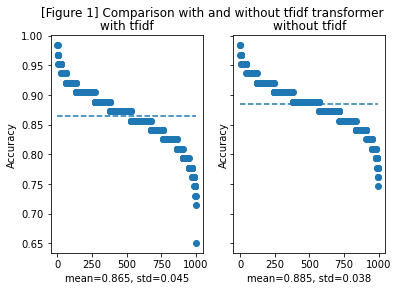

In [464]:
# Runs a bunch of predictions with random train/test splits to get an average accuracy.
def do_random_runs(with_tfidf: bool) -> [float]:
    accuracies = []
    for i in tqdm(range(1000)):
        x_train, x_test, y_train, y_test = split_data(features, labels)
        classifier = create_pipeline(with_tfidf=with_tfidf)
        classifier.fit(x_train, y_train)
        
        accuracies.append(accuracy_score(y_test,classifier.predict(x_test)))
    return accuracies


# Plot accuracies inside a subplot
def plot(ax, accuracies: [float]) -> None:
    accuracies.sort(reverse=True)
    mean = np.mean(accuracies)
    std = np.array(accuracies).std()

    ax.set_xlabel("mean={:.3f}, std={:.3f}".format(mean,std))
    ax.set_ylabel("Accuracy")
    x = range(0,len(accuracies))
    
    y = accuracies

    ax.scatter(x=x,y=y,label="Accuracy")
    ax.plot(x,[mean]*len(x),label="Mean", linestyle="--")

# Calculate and plot the difference when using a tfidf transformer or not
def compare_tfidf(features: [str], labels: [str]) -> None:
    fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True)
    fig.suptitle("[Figure 1] Comparison with and without tfidf transformer")
    
    # 1. with tfidf
    plot(ax1, do_random_runs(True))
    ax1.set_title("with tfidf")
    # 2. without tfidf
    plot(ax2, do_random_runs(False))
    ax2.set_title("without tfidf")

    plt.show()


# # Perform two tests:
# # 1. with    a tfidf transformer
# do_random_runs(ax1, with_tfidf=True, title="[Figure 1] Accuracies for different train/test splits with tfidf\nmean: {:.2f}, standard deviation: {:.3f}")
# # 2. without a tfidf transformer
# do_random_runs(ax2,with_tfidf=False, title="[Figure 2] Accuracies for different train/test splits without tfidf\nmean: {:.2f}, standard deviation: {:.3f}")

compare_tfidf(features,labels)

Initially I thought using a tfidf transformer would not increase our accuracy a lot because our features have fewer than 20 tokens that do not repeat often.

A mean accuracy of ~0.88 and standard deviation of ~0.04 is acceptable however the big range of accuracies depending on the shuffled train/test split is a result of the very small dataset. 

In [465]:
# Final model

x_train, x_test, y_train, y_test = train_test_split(features, labels, train_size=TRAIN_SIZE)
classifier = create_pipeline(with_tfidf=False)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)


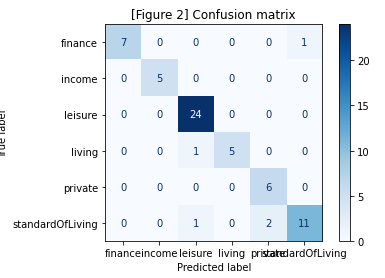

In [466]:
# Let's look at the confusion matrix for our model
plot = plot_confusion_matrix(classifier, x_test, y_test,cmap=plt.cm.Blues)
plot.ax_.set_title("[Figure 2] Confusion matrix")
plt.show()



In [467]:
# And print some statistict
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

         finance       1.00      0.88      0.93         8
          income       1.00      1.00      1.00         5
         leisure       0.92      1.00      0.96        24
          living       1.00      0.83      0.91         6
         private       0.75      1.00      0.86         6
standardOfLiving       0.92      0.79      0.85        14

        accuracy                           0.92        63
       macro avg       0.93      0.92      0.92        63
    weighted avg       0.93      0.92      0.92        63

